cSMC

In [1]:
import jax.numpy as jnp
from jax import random
from jax import grad, vmap, jit
from matplotlib import pyplot as plt
import seaborn as sns
from jax.config import config; config.update("jax_enable_x64", True)
%matplotlib inline

In [2]:
from melange.tests.utils import get_nondefault_potential_initializer, checker_function
from melange.smc import vSIS_lower_bound, SIS, generate_trajs, SIS_logW
import tqdm
from jax.lax import cond
import numpy as np
from melange.csmc import *

#define some parameters
N,T,Dx = 100, 10, 1
potential, (mu, cov), dG = get_nondefault_potential_initializer(Dx)
cov = cov[0]
dt=1e-2

#define some _vanilla_ A, b fns
A_fn = lambda x, params: params
b_fn = lambda x, params: params

#create the csmc container object
smc_obj= StaticULAControlledSMC(N, 
                            potential=potential,
                            forward_potential=potential, 
                            backward_potential=potential, 
                            A_fn = A_fn, #A_fn=lambda x, p: jnp.zeros((Dx, Dx)), 
                            b_fn = b_fn, #b_fn = lambda x, p: jnp.zeros(Dx),
                            A_params_len=1,
                            b_params_len=1,
                            Dx=1,
                            T=T
                           ) #create a controlled smc class

#create SMC parameters/functions
prop, logw, (init_Xs, init_logws) = smc_obj.get_fns() #pull the necessary functions from it
potential_params = jnp.linspace(0,1,T)[..., jnp.newaxis] #define the potential parameters

prop_params = {
               'potential_params': potential_params,
               'forward_potential_params': potential_params,
               'backward_potential_params': potential_params[1:],
               'dt': dt
               } #potential parameters dictionary goes here
init_params = {'mus': jnp.array([mu]), 
               'covs': jnp.array([cov]),
               'mixture_weights': jnp.array([1.])} #define the initial params
model_params=None #there are no model parameters
y=jnp.arange(T) #the y data aren't important. just know that there are the same number of them as there are data
rs = random.PRNGKey(6) #define a random number 

#create the trajectories
Xs = generate_trajs(prop_params, model_params, y, rs, init_params, init_Xs, prop)
logWs = SIS_logW(Xs, prop_params, model_params, y, init_params, logw, init_logws, aggregate_works=False)
aggregated_logWs = jnp.cumsum(logWs, axis=0)
logZ = logsumexp(aggregated_logWs[-1,:]) - jnp.log(N)
print(f"the estimated logZ is {logZ}; the True logZ is {dG}")


DEBUG:absl:Initializing backend 'interpreter'
DEBUG:absl:Initializing backend 'cpu'
DEBUG:absl:Initializing backend 'gpu'
DEBUG:absl:Error initializing backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')
Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)
DEBUG:absl:Compiling _where for args (ShapedArray(bool[1,1]), ShapedArray(float64[1]), ShapedArray(float64[1])).
Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)
Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)
Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)
Level 9:absl:get_compile_options: num_replicas=1 nu

the estimated logZ is -0.3309316707090595; the True logZ is -0.3465


let's see if we can't get the twisting functions...

In [3]:
ADP_dict = smc_obj.get_ADP_fn()
print(ADP_dict.keys())
ADP_fn = ADP_dict['ADP']

dict_keys(['utilities', 'ADP'])


In [4]:
out_dict = ADP_fn(Xs, logWs, prop_params, verbose=True)

  0%|          | 0/9 [00:00<?, ?it/s]Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)
Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)
Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)
DEBUG:absl:Compiling _where for args (ShapedArray(bool[1,1]), ShapedArray(float64[1,1]), ShapedArray(float64[1,1])).
Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)
100%|██████████| 9/9 [00:04<00:00,  1.85it/s]


In [6]:
out_dict

{'losses': array([[2.63589304e-01, 1.80213411e-06],
        [1.72694117e+00, 1.47119806e+02],
        [1.75937544e+00, 1.50572245e+02],
        [1.82587472e+00, 1.56879640e+02],
        [1.77235697e+00, 1.52702972e+02],
        [1.74360282e+00, 1.51124501e+02],
        [1.70710334e+00, 1.47776157e+02],
        [1.51841437e+00, 1.30487521e+02],
        [1.17127262e+00, 1.00474560e+02],
        [6.32672756e-01, 5.47277550e+01]]),
 'out_A_params': array([[0.        ],
        [0.01714386],
        [0.01636685],
        [0.0165804 ],
        [0.01635617],
        [0.0160494 ],
        [0.01611148],
        [0.01605162],
        [0.01428961],
        [0.00999279]]),
 'out_b_params': array([[ 0.00000000e+00],
        [ 4.77967698e-04],
        [ 2.81921784e-04],
        [-1.87274466e-04],
        [-8.60159443e-04],
        [ 5.85031529e-05],
        [-6.78506955e-04],
        [-9.85206710e-04],
        [-1.46550472e-03],
        [-5.96509005e-04]]),
 'out_A0': array([0.01707836]),
 'out_b0':

In [6]:
out_dict['losses']

array([[2.63589304e-01, 1.80213411e-06],
       [1.72694117e+00, 1.47119806e+02],
       [1.75937544e+00, 1.50572245e+02],
       [1.82587472e+00, 1.56879640e+02],
       [1.77235697e+00, 1.52702972e+02],
       [1.74360282e+00, 1.51124501e+02],
       [1.70710334e+00, 1.47776157e+02],
       [1.51841437e+00, 1.30487521e+02],
       [1.17127262e+00, 1.00474560e+02],
       [6.32672756e-01, 5.47277550e+01]])

In [23]:
from melange.csmc import *

In [26]:
def test_uncontrolled_csmc(dim=1):
    """
    test a vanilla implementation of uncontrolled sequential monte carlo of a static model with an Euler Maruyama forward/backward kernel.
    the cSMC twisted weights should be the same as the uncontrolled SMC weights
    """
    from melange.tests.utils import get_nondefault_potential_initializer, checker_function
    from melange.smc import generate_trajs, SIS_logW
    from melange.smc_objects import StaticULA
    
    N,T,Dx = 10000, 1000, dim #define some smc parameters
    potential, (mu, cov), dG = get_nondefault_potential_initializer(Dx) #get the potential and the starting distribution parameters
    cov = cov[0] #rework the covariance matrix so that it is a vector (squashed diagonal)
    dt=1e-2 #timestep
    
    dummy_A = lambda x, param: jnp.zeros(Dx) #create a dummy A function
    dummy_b = lambda x, param: jnp.zeros(Dx) #create adummy b function
    
    base_smc_obj = StaticULA(N, potential, potential, potential) #define a static ULA object so we can pull the _compute_log_work_function
    base_twisted_logW_fn = base_smc_obj.log_weights_fn() #pull out the log weight function of the uncontrolled SMC
    
    smc_obj= StaticULAControlledSMC(N, 
                                potential=potential,
                                forward_potential=potential, 
                                backward_potential=potential, 
                                A_fn = dummy_A, #A_fn=lambda x, p: jnp.zeros((Dx, Dx)), 
                                b_fn = dummy_b, #b_fn = lambda x, p: jnp.zeros(Dx),
                                A_params_len=1,
                                b_params_len=1,
                                Dx=1,
                                T=T
                               ) #create a controlled smc class
    
    prop, logw, (init_Xs, init_logws) = smc_obj.get_fns() #pull the necessary functions from it
    potential_params = jnp.linspace(0,1,T)[..., jnp.newaxis] #define the potential parameters
    
    prop_params = {
                   'potential_params': potential_params,
                   'forward_potential_params': potential_params,
                   'backward_potential_params': potential_params[1:],
                   'dt': dt
                   } #potential parameters dictionary goes here

    init_params = {'mus': jnp.array([mu]), 
                   'covs': jnp.array([cov]),
                   'mixture_weights': jnp.array([1.])} #define the initial params
    
    model_params=None #there are no model parameters
    y=jnp.arange(T) #the y data aren't important. just know that there are the same number of them as there are data
    rs = random.PRNGKey(5) #define a random number 
    
    #generate trajectories and assert that (with sufficiently long annealing), the initial and final distributions are appropriately placed
    Xs = generate_trajs(prop_params, model_params, y, rs, init_params, init_Xs, prop)
    assert np.isclose(Xs[0,:,:].var(), 2., atol=2e-1)
    assert np.isclose(Xs[-1,:,:].var(), 1., atol=1e-1)
    
    #compute weights (there is a problem here because twisting should give me constant offsets that i dont want)
    vtwist_fn = smc_obj.vtwist_fn
    untwisted_logW_fn = smc_obj.log_weights_fn()
    twisted_mus, twisted_covs, logK_Zs, (As, bs) = vtwist_fn(Xs[0], 
                                                             smc_obj.forward_potential, 
                                                             prop_params['dt'], 
                                                             prop_params['forward_potential_params'][0],
                                                             smc_obj.A_fn, 
                                                             smc_obj.b_fn,
                                                             smc_obj.A_params_cache[:smc_obj.twisting_iteration],
                                                             smc_obj.b_params_cache[:smc_obj.twisting_iteration],
                                                             True)
    
    # assert all of the logK_Zs are close to zero
    assert np.allclose(logK_Zs, 0.)
    
    # assert all twists are zeros
    assert np.allclose(As.flatten(), 0.)
    assert np.allclose(bs.flatten(), 0.)
    
    #_just_ do the twisting potential and make sure it is zero
    log_psi_ts = smc_obj.vlog_psi_twist(Xs[0], As, bs)
    assert np.allclose(log_psi_ts, 0.)
    
    #compute twisted log weights:
    logWs = SIS_logW(Xs, prop_params, model_params, y, init_params, logw, init_logws)
    assert np.isclose(logsumexp(logWs[-1,:]) - jnp.log(N), )
    
    return Xs, logsumexp(logWs[-1,:]) - jnp.log(N)
    
Xs, logWs = test_null_twist(dim=1)   

In [27]:
logWs

DeviceArray(-0.34411429, dtype=float64)

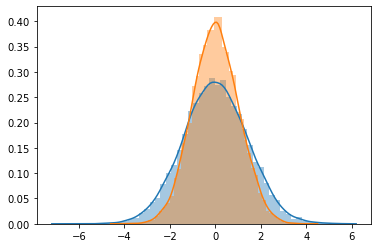

In [37]:
sns.distplot(Xs[0,:,:])
sns.distplot(Xs[-1,:,:])

how will we minimize?


In [12]:
import numpy as np
from scipy.optimize import minimize

In [13]:
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)
jit_rosen=jit(rosen)

In [14]:
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])

In [15]:
rosen(x0)

848.22

In [18]:
energy_history = []
x_values = []
def callback(x):
    fobj = jit_rosen(x)
    energy_history.append(fobj)
    x_values.append(x)

In [19]:
out = minimize(jit_rosen,x0 = x0, method='L-BFGS-B', options={'disp':1}, callback = callback)

In [20]:
dir(out)

['fun', 'hess_inv', 'jac', 'message', 'nfev', 'nit', 'status', 'success', 'x']

In [53]:
out['x'].dtype

dtype('float64')

In [10]:
a = jnp.asarray(np.random.randn(3,3))
b = jnp.asarray(np.random.randn(3))

In [11]:
jnp.vstack((a,b))

Level 9:absl:get_compile_options: num_replicas=1 num_partitions=1 device_assignment=(0,)


DeviceArray([[-0.6738118 , -0.71250094, -0.02713342],
             [-0.19548071, -0.69893683,  0.36365833],
             [-0.39087161,  0.04401595, -1.06750039],
             [ 0.09134596,  1.10062331,  1.62327804]], dtype=float64)

In [14]:
def square(x):
    return (x-1)**2
vsquare = vmap(square)
out_fn = lambda x: vsquare(x).sum()

out = minimize(out_fn, x0 = np.random.randn(3,3)*100, method='L-BFGS-B', options={'disp':True})

In [15]:
out

      fun: DeviceArray(2.69886881e-16, dtype=float64)
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.51797942e-09, -2.24263495e-09,  8.80799771e-10, -2.55183650e-09,
       -4.71546471e-10, -3.77173283e-09,  5.62467847e-10,  2.73691290e-10,
       -1.57714653e-09])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 60
      nit: 3
   status: 0
  success: True
        x: array([1.        , 0.99999999, 1.        , 0.99999999, 0.99999999,
       0.99999999, 1.        , 1.        , 0.99999999])

In [18]:
out['x'].reshape(3,3)

array([[1.        , 0.99999999, 1.        ],
       [0.99999999, 0.99999999, 0.99999999],
       [1.        , 1.        , 0.99999999]])

In [6]:
smc_obj= StaticULAControlledSMC(N, 
                                potential=potential,
                                forward_potential=potential, 
                                backward_potential=potential, 
                                A_fn = A_twist_fn, #A_fn=lambda x, p: jnp.zeros((Dx, Dx)), 
                                b_fn = b_twist_fn, #b_fn = lambda x, p: jnp.zeros(Dx),
                                A_params_len=1,
                                b_params_len=1,
                                Dx=1
                               )
prop, logw, inits = smc_obj.get_fns()
potential_params = jnp.linspace(0,1,T)[..., jnp.newaxis]
prop_params = {
               'potential_params': potential_params,
               'forward_potential_params': potential_params,
               'backward_potential_params': potential_params[1:],
               'dt': dt
               }

init_params = {'mus': jnp.array([mu]), 
               'covs': jnp.array([cov]),
               'mixture_weights': jnp.array([1.])}

model_params=None
y=jnp.zeros(T)
rs = random.PRNGKey(10)
jSIS_lower_bound = jit(vSIS_lower_bound, static_argnums=(5,6,7))
jSIS = jit(SIS, static_argnums=(5,6,7)) #SIS(prop_params, model_params, y,  rs, init_params, prop_fn, logW_fn, init_fns)
logZs = []

for i in tqdm.trange(1):
    rs, run_rs = random.split(rs, 2)
    logZ = vSIS_lower_bound(prop_params, model_params, y, run_rs, init_params, prop, logw, inits)
    logZs.append(logZ)

print(f"doing base SIS")
Xs, untwisted_logWs = jSIS(prop_params, model_params, y, rs, init_params, prop, logw, inits, aggregate_works=False)
print('done')
    



100%|██████████| 1/1 [00:05<00:00,  5.02s/it]


doing base SIS
done


In [7]:
dG

-0.3465

In [8]:
jnp.array(logZs).mean()

DeviceArray(-21.059101, dtype=float32)

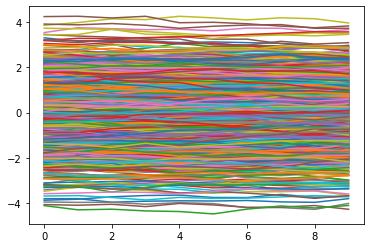

In [12]:
for i in range(1000):
    plt.plot(Xs[:,i,:])

/home/dominic/anaconda3/envs/openmm/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


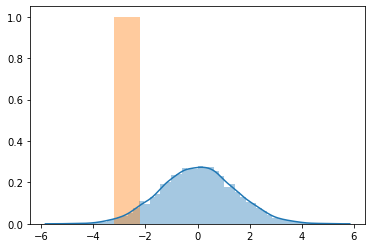

In [15]:
sns.distplot(random.normal(key=random.PRNGKey(0), shape=(10000,))*jnp.sqrt(cov))
sns.distplot(Xs[0,i,:])

ok, so this looks ok

## for the ADP (lord help me)

In [9]:
losses, grad_losses, optimize_fn, ADP_fn = smc_obj.get_ADP_fn()

In [10]:
new_param_dct, losses_arr, init_losses_arr = ADP_fn(Xs, 
                                                    random.PRNGKey(42), 
                                                    untwisted_logWs, 
                                                    prop_params, 
                                                    init_params, 
                                                    opt_steps=1000,
                                                    learning_rates_0={'A0': 1e-5, 'b0': 1e-5})

  0%|          | 0/9 [00:00<?, ?it/s]

iterating backward...
t: 9; initial loss: 90.28929138183594
optimized parameters: {'A_params': DeviceArray([-56.194862], dtype=float32), 'b_params': DeviceArray([-0.14679931], dtype=float32)}
twisting A params: [[  0.      ]
 [-56.194862]]
twist b params: [[ 0.        ]
 [-0.14679931]]


 11%|█         | 1/9 [00:01<00:13,  1.68s/it]

t: 8; initial loss: 72244168.0
optimized parameters: {'A_params': DeviceArray([-55.792953], dtype=float32), 'b_params': DeviceArray([0.01488524], dtype=float32)}
twisting A params: [[  0.      ]
 [-55.792953]]
twist b params: [[0.        ]
 [0.01488524]]


 22%|██▏       | 2/9 [00:01<00:08,  1.24s/it]

t: 7; initial loss: 73184264.0
optimized parameters: {'A_params': DeviceArray([-62.749123], dtype=float32), 'b_params': DeviceArray([0.07351948], dtype=float32)}
twisting A params: [[  0.      ]
 [-62.749123]]
twist b params: [[0.        ]
 [0.07351948]]


 33%|███▎      | 3/9 [00:02<00:05,  1.07it/s]

t: 6; initial loss: 73946816.0
optimized parameters: {'A_params': DeviceArray([-68.571884], dtype=float32), 'b_params': DeviceArray([0.12859744], dtype=float32)}
twisting A params: [[  0.      ]
 [-68.571884]]
twist b params: [[0.        ]
 [0.12859744]]


 44%|████▍     | 4/9 [00:02<00:03,  1.38it/s]

t: 5; initial loss: 74741664.0
optimized parameters: {'A_params': DeviceArray([-74.96388], dtype=float32), 'b_params': DeviceArray([0.06939767], dtype=float32)}
twisting A params: [[  0.     ]
 [-74.96388]]
twist b params: [[0.        ]
 [0.06939767]]


 56%|█████▌    | 5/9 [00:02<00:02,  1.74it/s]

t: 4; initial loss: 75185112.0
optimized parameters: {'A_params': DeviceArray([-78.34155], dtype=float32), 'b_params': DeviceArray([0.23034683], dtype=float32)}
twisting A params: [[  0.     ]
 [-78.34155]]
twist b params: [[0.        ]
 [0.23034683]]


 67%|██████▋   | 6/9 [00:02<00:01,  2.14it/s]

t: 3; initial loss: 75328984.0
optimized parameters: {'A_params': DeviceArray([-78.976166], dtype=float32), 'b_params': DeviceArray([0.65710646], dtype=float32)}
twisting A params: [[  0.      ]
 [-78.976166]]
twist b params: [[0.        ]
 [0.65710646]]


 78%|███████▊  | 7/9 [00:03<00:00,  2.50it/s]

t: 2; initial loss: 75302760.0


 89%|████████▉ | 8/9 [00:03<00:00,  2.78it/s]

optimized parameters: {'A_params': DeviceArray([-78.01529], dtype=float32), 'b_params': DeviceArray([0.8420237], dtype=float32)}
twisting A params: [[  0.     ]
 [-78.01529]]
twist b params: [[0.       ]
 [0.8420237]]
t: 1; initial loss: 75218032.0


100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

optimized parameters: {'A_params': DeviceArray([-76.50562], dtype=float32), 'b_params': DeviceArray([0.9285487], dtype=float32)}
twisting A params: [[  0.     ]
 [-76.50562]]
twist b params: [[0.       ]
 [0.9285487]]


In [11]:
smc_obj.update_twist(new_param_dct)

let's check the smc object

In [12]:
print(smc_obj.twisting_iteration)
print(smc_obj.A0)
print(smc_obj.b0)
print(smc_obj.A_params_cache)
print(smc_obj.b_params_cache)

1
[[nan]]
[nan]
[[[  0.      ]
  [-76.50562 ]
  [-78.01529 ]
  [-78.976166]
  [-78.34155 ]
  [-74.96388 ]
  [-68.571884]
  [-62.749123]
  [-55.792953]
  [-56.194862]]

 [[  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]]

 [[  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]]

 [[  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]]

 [[  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]]

 [[  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]]

 [[  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.      ]
  [  0.     

ok, can we try to run a twisted iteration?

In [13]:
prop, logw, inits = smc_obj.get_fns()

In [14]:
jSIS_lower_bound = jit(vSIS_lower_bound, static_argnums=(5,6,7))

In [15]:
rs = random.PRNGKey(34)
twist_logZs = []
for i in tqdm.trange(100):
    rs, run_rs = random.split(rs, 2)
    logZ = jSIS_lower_bound(prop_params, model_params, y, run_rs, init_params, prop, logw, inits)
    twist_logZs.append(logZ)

print(f"doing base SIS")
Xs, twisted_logWs = jSIS(prop_params, model_params, y, rs, init_params, prop, logw, inits, aggregate_works=False)
print('done')
    


100%|██████████| 100/100 [00:03<00:00, 27.90it/s]


doing base SIS
done


In [16]:
twisted_logWs.shape

(10, 1000)

In [17]:
jnp.array(twist_logZs).mean()

DeviceArray(-0.34653977, dtype=float32)

Text(0, 0.5, 'density')

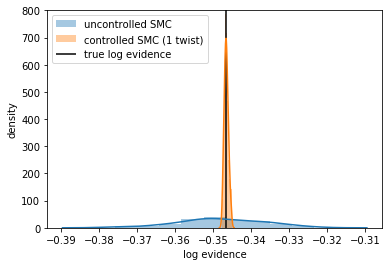

In [18]:
sns.distplot(logZs, label='uncontrolled SMC')
sns.distplot(twist_logZs, label='controlled SMC (1 twist)')
plt.vlines(dG, 0,800, label='true log evidence')
plt.ylim(0,800)
plt.legend()
plt.xlabel(f"log evidence")
plt.ylabel(f"density")

In [19]:
losses, grad_losses, optimize_fn, ADP_fn = smc_obj.get_ADP_fn()

In [20]:
new_param_dct, losses_arr, init_losses_arr = ADP_fn(Xs, 
                                                    random.PRNGKey(42), 
                                                    twisted_logWs, 
                                                    prop_params, 
                                                    init_params, 
                                                    opt_steps=1000,
                                                    learning_rates_0={'A0': 1e-5, 'b0': 1e-5})

  0%|          | 0/9 [00:00<?, ?it/s]

iterating backward...
t: 9; initial loss: 2.352574586868286
optimized parameters: {'A_params': DeviceArray([0.02777491], dtype=float32), 'b_params': DeviceArray([0.00017573], dtype=float32)}
twisting A params: [[0.02761868]
 [0.02777491]]
twist b params: [[-0.00014188]
 [ 0.00017573]]


 11%|█         | 1/9 [00:00<00:02,  3.46it/s]

t: 8; initial loss: 19.79930877685547
optimized parameters: {'A_params': DeviceArray([0.08117654], dtype=float32), 'b_params': DeviceArray([-0.00045195], dtype=float32)}
twisting A params: [[0.05527914]
 [0.08117654]]
twist b params: [[-0.00018345]
 [-0.00045195]]


 22%|██▏       | 2/9 [00:00<00:01,  3.67it/s]

t: 7; initial loss: 76.38909912109375
optimized parameters: {'A_params': DeviceArray([0.1611653], dtype=float32), 'b_params': DeviceArray([-0.00200456], dtype=float32)}
twisting A params: [[0.0828969]
 [0.1611653]]
twist b params: [[-4.7316571e-05]
 [-2.0045561e-03]]


 33%|███▎      | 3/9 [00:00<00:01,  3.78it/s]

t: 6; initial loss: 210.3072967529297
optimized parameters: {'A_params': DeviceArray([0.2689866], dtype=float32), 'b_params': DeviceArray([-0.00059998], dtype=float32)}
twisting A params: [[0.11011182]
 [0.2689866 ]]
twist b params: [[ 0.00012336]
 [-0.00059998]]


 44%|████▍     | 4/9 [00:01<00:01,  3.84it/s]

t: 5; initial loss: 468.725830078125
optimized parameters: {'A_params': DeviceArray([0.39778167], dtype=float32), 'b_params': DeviceArray([-0.0009053], dtype=float32)}
twisting A params: [[0.1369963 ]
 [0.39778167]]
twist b params: [[ 0.00011628]
 [-0.0009053 ]]


 56%|█████▌    | 5/9 [00:01<00:01,  3.99it/s]

t: 4; initial loss: 872.512939453125
optimized parameters: {'A_params': DeviceArray([0.55107117], dtype=float32), 'b_params': DeviceArray([0.00042376], dtype=float32)}
twisting A params: [[0.16334553]
 [0.55107117]]
twist b params: [[2.3297016e-05]
 [4.2376152e-04]]


 67%|██████▋   | 6/9 [00:01<00:00,  4.06it/s]

t: 3; initial loss: 1513.4588623046875
optimized parameters: {'A_params': DeviceArray([0.7302874], dtype=float32), 'b_params': DeviceArray([0.00440207], dtype=float32)}
twisting A params: [[0.18970983]
 [0.7302874 ]]
twist b params: [[0.00049331]
 [0.00440207]]


 78%|███████▊  | 7/9 [00:01<00:00,  4.04it/s]

t: 2; initial loss: 2498.88427734375
optimized parameters: {'A_params': DeviceArray([0.92457175], dtype=float32), 'b_params': DeviceArray([0.00066601], dtype=float32)}
twisting A params: [[0.2155855 ]
 [0.92457175]]
twist b params: [[0.00104538]
 [0.00066601]]


 89%|████████▉ | 8/9 [00:01<00:00,  4.13it/s]

t: 1; initial loss: 3782.283935546875
optimized parameters: {'A_params': DeviceArray([1.1399895], dtype=float32), 'b_params': DeviceArray([-0.00361299], dtype=float32)}
twisting A params: [[0.24124295]
 [1.1399895 ]]
twist b params: [[ 0.0016072 ]
 [-0.00361299]]


100%|██████████| 9/9 [00:02<00:00,  4.10it/s]


In [26]:
losses_arr

DeviceArray([[4.5078994e+03, 3.9918843e+03, 3.5360549e+03, ...,
              8.0459534e+01, 8.0459534e+01, 8.0459534e+01],
             [3.7822839e+03, 3.3549795e+03, 2.9760068e+03, ...,
              3.0151620e+00, 3.0151620e+00, 3.0151620e+00],
             [2.4988843e+03, 2.2155190e+03, 1.9643240e+03, ...,
              2.2535410e+00, 2.2535410e+00, 2.2535410e+00],
             ...,
             [7.6389099e+01, 6.7769112e+01, 6.0128262e+01, ...,
              4.8120111e-01, 4.8120111e-01, 4.8120111e-01],
             [1.9799309e+01, 1.7551268e+01, 1.5562107e+01, ...,
              2.7208564e-01, 2.7208564e-01, 2.7208564e-01],
             [2.3525746e+00, 2.0999529e+00, 1.8758588e+00, ...,
              1.1430583e-01, 1.1430583e-01, 1.1430583e-01]],            dtype=float32)

In [21]:
smc_obj.update_twist(new_param_dct)

In [22]:
new_param_dct

{'A0': DeviceArray([[1.2154009]], dtype=float32),
 'b0': DeviceArray([0.00343322], dtype=float32),
 'A_params': DeviceArray([[0.        ],
              [1.1399895 ],
              [0.92457175],
              [0.7302874 ],
              [0.55107117],
              [0.39778167],
              [0.2689866 ],
              [0.1611653 ],
              [0.08117654],
              [0.02777491]], dtype=float32),
 'b_params': DeviceArray([[ 0.        ],
              [-0.00361299],
              [ 0.00066601],
              [ 0.00440207],
              [ 0.00042376],
              [-0.0009053 ],
              [-0.00059998],
              [-0.00200456],
              [-0.00045195],
              [ 0.00017573]], dtype=float32)}

In [29]:
(twisted_logWs[-1]**2).sum()

DeviceArray(2.3525746, dtype=float32)

ok, can we twist this again?!, but for safety's sake, let's try to do it manually. but first, let's plot the twisted logWs

In [23]:
cum_twist_logWs = jnp.cumsum(twisted_logWs, axis=0)

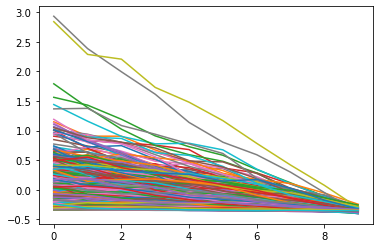

In [28]:
for i in range(1000):
    plt.plot(cum_twist_logWs[:,i])

ok, now let's try to twist these....

In [31]:
start_A_twist_params = smc_obj.A_params_cache[0]
start_b_twist_params = smc_obj.b_params_cache[0]

In [31]:
logK_int_twists = jnp.zeros(smc_obj.N)

In [32]:
Vbar_ts = -twisted_logWs[9] - logK_int_twists

NameError: name 't' is not defined

In [34]:
(Vbar_ts**2).sum()

DeviceArray(2.3525746, dtype=float32)

In [35]:
from jax import value_and_grad
def loss_t(params, Xps, Xcs, Vbars):
    As, bs = params
    return ((-smc_obj.vlog_psi_t_twist(Xps, Xcs, smc_obj.base_A_fn, smc_obj.base_b_fn, As, bs) - Vbars)**2).sum()
val_and_grad_loss = jit(value_and_grad(loss_t))

In [36]:
start_params = (jnp.zeros(1), jnp.zeros(1))
lr=1e-6
import tqdm
losses = []
for epoch in tqdm.trange(1000):
    loss, grads = val_and_grad_loss(start_params, Xs[8], Xs[9], Vbar_ts)
    losses.append(loss)
    As, bs = start_params
    As = As - grads[0]*lr
    bs = bs - grads[1]*lr
    start_params = (As, bs)

100%|██████████| 1000/1000 [00:02<00:00, 384.48it/s]


In [37]:
start_params

(DeviceArray([0.02768037], dtype=float32),
 DeviceArray([-6.7175526e-05], dtype=float32))

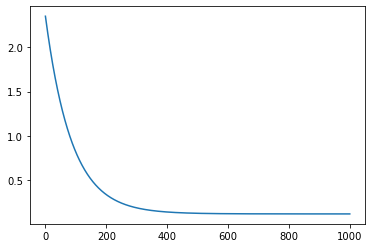

In [38]:
plt.plot(losses)

In [158]:
def new_potential(pos, parameter):
    mod_parameter = parameter[0]
    dim = pos.shape[0]
    x0 = jnp.ones(pos.shape)
    x1 = x0*1.5
    k0, k1 = 0.5 * jnp.diag(jnp.ones(dim)), 4.*jnp.diag(jnp.ones(dim))
    start_pot = 0.5*(1. - mod_parameter) * jnp.dot(jnp.dot(pos, k0), pos)
    end_pot = mod_parameter*((pos**4).sum() - 8*(pos**2).sum())
    return start_pot + end_pot

In [159]:
vnew_potential = vmap(new_potential, in_axes=(0, None))

In [160]:
energies = vnew_potential(supports[..., jnp.newaxis], jnp.array([0.]))
new_energies = vnew_potential(supports[..., jnp.newaxis], jnp.array([1.]))

In [182]:
def make_gmm_potential(x, parameters):
    xpos = x[0]
    return -1.*jnp.log(0.3*jnp.exp(-0.5*(xpos+2)**2) 
                   + 0.4*jnp.exp(-0.2*(xpos+1.)**2)
                   + 0.3*jnp.exp(-0.7*(xpos-4.)**2)
                   + jnp.exp(-1*(xpos-3.)**2)
                  )

In [183]:
vgmm = vmap(make_gmm_potential, in_axes=(0,None))

In [184]:
nergies = vgmm(supports[..., jnp.newaxis], jnp.array([0.]))

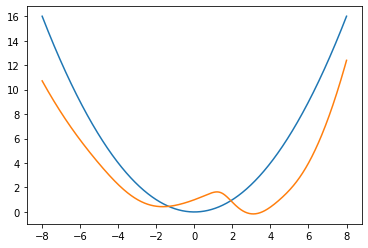

In [185]:
plt.plot(supports, energies)
plt.plot(supports, nergies.flatten())

In [241]:
jnp.zeros((1,1,1))[:0,5,:]

DeviceArray([], dtype=float32)

In [243]:
blank = jnp.array([])
a = jnp.zeros(3)

In [ ]:
jnp.vstack((blank))

In [244]:
jnp.concatenate(blank, a)

ValueError: Need at least one array to concatenate.

In [245]:
a = jnp.zeros((3,4))

In [246]:
b = jnp.ones(4)

In [249]:
jnp.vstack((a, b[jnp.newaxis, ...]))

DeviceArray([[0., 0., 0., 0.],
             [0., 0., 0., 0.],
             [0., 0., 0., 0.],
             [1., 1., 1., 1.]], dtype=float32)

In [1]:
a = (1,2)

In [2]:
a + (3,)

(1, 2, 3)